# 2. Labeling, structuring and visualizing the data
In this step, we wanted to gain an understanding of how the collected data could inform ML-generated predictions. To do so, we started by organizing and structuring the datasets so that they could be used to create meaningful visualizations, and to enable its interpretation by an algorithm. Where necessary, we added labels that add a layer of meaningful information to the data for the algorithm to use. For the grocery automation case study, we poured the data into a full dataset of all items bought by each individual household. Examples of labels that were added to the data are: an identification of what types of items each item name signified (e.g., "Old Goudse 45+" is cheese); an identification of what type of store the items were bought at (e.g., "Albert Heijn" is a supermarket), and assigning a category to which each item belongs (e.g., milk is a dairy product).

In this notebook we:
1. Import the library/dataframe and recode/add all required variables (2.1 Labeling and structuring)
2. Generate visualizations and correlations to analyze the data (2.2 Visualizing)


<!-- 1. build grid: when do/dont they shop, how many times, on which day...
2. define priliminaries for algorithm
3. define filters for algorithm
4. RUN algorithm 


----


Outcome (example):
1. input: rows of dow shopped
2. output: 0,1,2,0,0,1,0 -->

## 2.1. Labeling and structuring

### Import libraries 

In [1]:
# %matplotlib notebook
%matplotlib inline
#Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
from datetime import time
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from scipy.stats import chi2_contingency

### Load and view data 

In [2]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
# del df["HH"]
df.head()

,HH,week,order_ID,item_name,amount,price_unit,price_total,date,day,timestamp,...,item_id,type_id,order_amount,order_price,day_num,storetype_num,storename_num,cat_num,time_num,promo_num
0,2,1,1,RABEKO choco light 250g,2,2.82,5.64,2021-11-23,Tuesday,12:32:00,...,0,0,9,16.77,5,4,6,2,3,0
1,2,1,1,JOYVALLE pudding griesmeel natuur 135g,4,0.99,3.96,2021-11-23,Tuesday,12:32:00,...,1,1,9,16.77,5,4,6,7,3,0
2,2,1,1,BONI tomatensoep met balletjes 950ml,1,1.99,1.99,2021-11-23,Tuesday,12:32:00,...,2,2,9,16.77,5,4,6,3,3,0
3,2,1,1,LIEBIG DELISOUP 9 groenten brik 1L,1,2.59,2.59,2021-11-23,Tuesday,12:32:00,...,3,2,9,16.77,5,4,6,3,3,0
4,2,1,1,LIEBIG DELISOUP tom. Balletjes brik 1L,1,2.59,2.59,2021-11-23,Tuesday,12:32:00,...,4,2,9,16.77,5,4,6,3,3,0


## 2.1.1. Recode variables


Create (number) IDs for certain variables (item type, order...)
Create new derived variables (e.g. reordering an item, total order price...)
Make sure all variables are formatted as the correct type (e.g., int, bool...)

In [3]:
# new row for reordered items 
df['reorder'] = df.item_type.duplicated()

# convert reorder row to boolean value
df['reorder'] = df['reorder'].astype(bool)

#create an ID for each item 
df.rename(columns={'item_id':'item_name'}, inplace=True)
df['item_id'] = pd.factorize(df['item_name'])[0]

#create an ID for each type 
df['type_id'] = pd.factorize(df['item_type'])[0]

#first make a new column for the amount of items per order
df['order_amount'] = df.groupby('order_ID')['amount'].transform('sum')

# make a new column for the price per order
df['order_price'] = df.groupby('order_ID')['price_total'].transform('sum')

/tmp/ipykernel_55135/3230577030.py:9: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['item_id'] = pd.factorize(df['item_name'])[0]


ValueError: could not broadcast input array from shape (372,2) into shape (372,)

In [7]:
df['week'] = df['week'].astype(int)

df['order_ID'] = df['order_ID'].astype(int)

df['amount'] = df['amount'].astype(int)

df['promo'] = df['promo'].astype(bool)

df['item_id'] = df['item_id'].astype(int)

df['type_id'] = df['type_id'].astype(int)

KeyError: 'item_id'

In [8]:
df_des = df.describe(include='all')

df_styled = df_des.style.background_gradient() #adding a gradient based on values in cell
# dfi.export(df_styled,"describeHH2.png")
df_styled

ValueError: could not convert string to float: 'GROF BROOD GESN.'

### New (numeric) variables for the confusion matrix

Turn numeric values into category codes (to facilitate making the confusion matrix)

In [9]:
# Recode dow
df['day_num']=df['day'].astype('category').cat.codes

# Recode store_type
df['storetype_num']=df['store_type'].astype('category').cat.codes

# Recode store_name
df['storename_num']=df['store_name'].astype('category').cat.codes

# Recode categories
df['cat_num']=df['category'].astype('category').cat.codes

# Recode time
df['time_num']=df['time'].astype('category').cat.codes

# Recode time
df['promo_num']=df['promo'].astype('category').cat.codes

In [10]:
df.dtypes

week               int64
order_ID           int64
item_name         object
amount             int64
price_unit       float64
price_total      float64
date              object
day               object
timestamp         object
time              object
store_type        object
store_name        object
promo               bool
item_type         object
category          object
reorder             bool
item_name          int64
type_id            int64
order_amount       int64
order_price      float64
day_num             int8
storetype_num       int8
storename_num       int8
cat_num             int8
time_num            int8
promo_num           int8
dtype: object

## 2.1.2. Save the final dataframe as a new csv file

In [11]:
df.to_csv(r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv", index=False)
# df.drop(["storename_num", 'cat_num', 'time_num', 'promo_num', 'timestamp'], axis=1, inplace=True)
# df.drop(['day_num', 'storetype_num', 'reorder'], axis=1, inplace=True)
df.head()

,week,order_ID,item_name,amount,price_unit,price_total,date,day,timestamp,time,...,item_name,type_id,order_amount,order_price,day_num,storetype_num,storename_num,cat_num,time_num,promo_num
0,1,1,RABEKO choco light 250g,2,2.82,5.64,2021-11-23,Tuesday,12:32:00,noon,...,0,0,9,16.77,5,4,6,2,3,0
1,1,1,JOYVALLE pudding griesmeel natuur 135g,4,0.99,3.96,2021-11-23,Tuesday,12:32:00,noon,...,1,1,9,16.77,5,4,6,7,3,0
2,1,1,BONI tomatensoep met balletjes 950ml,1,1.99,1.99,2021-11-23,Tuesday,12:32:00,noon,...,2,2,9,16.77,5,4,6,3,3,0
3,1,1,LIEBIG DELISOUP 9 groenten brik 1L,1,2.59,2.59,2021-11-23,Tuesday,12:32:00,noon,...,3,2,9,16.77,5,4,6,3,3,0
4,1,1,LIEBIG DELISOUP tom. Balletjes brik 1L,1,2.59,2.59,2021-11-23,Tuesday,12:32:00,noon,...,4,2,9,16.77,5,4,6,3,3,0


## 2.2. Visualizing 

Now that we have a structured dataset, we can visualize it to try to identify patterns in the data, and look for statistical correlations. The patterns that are found in the dataset inform the order in which the predictions would be structured. For instance, once we know on which days the households may shop, we can identify another variable has the highest correlation to the day variable. If that variable would for instance be the type of store, then this becomes the next variable we could look at (i.e., if day is a predictor for store type, subsequently store type may be a predictor for amount of items bought, and so on).

In this section we:
1. Create & export a confusion matrix
2. Analyze visualizations and correlations for all relevant variables

<Axes: >

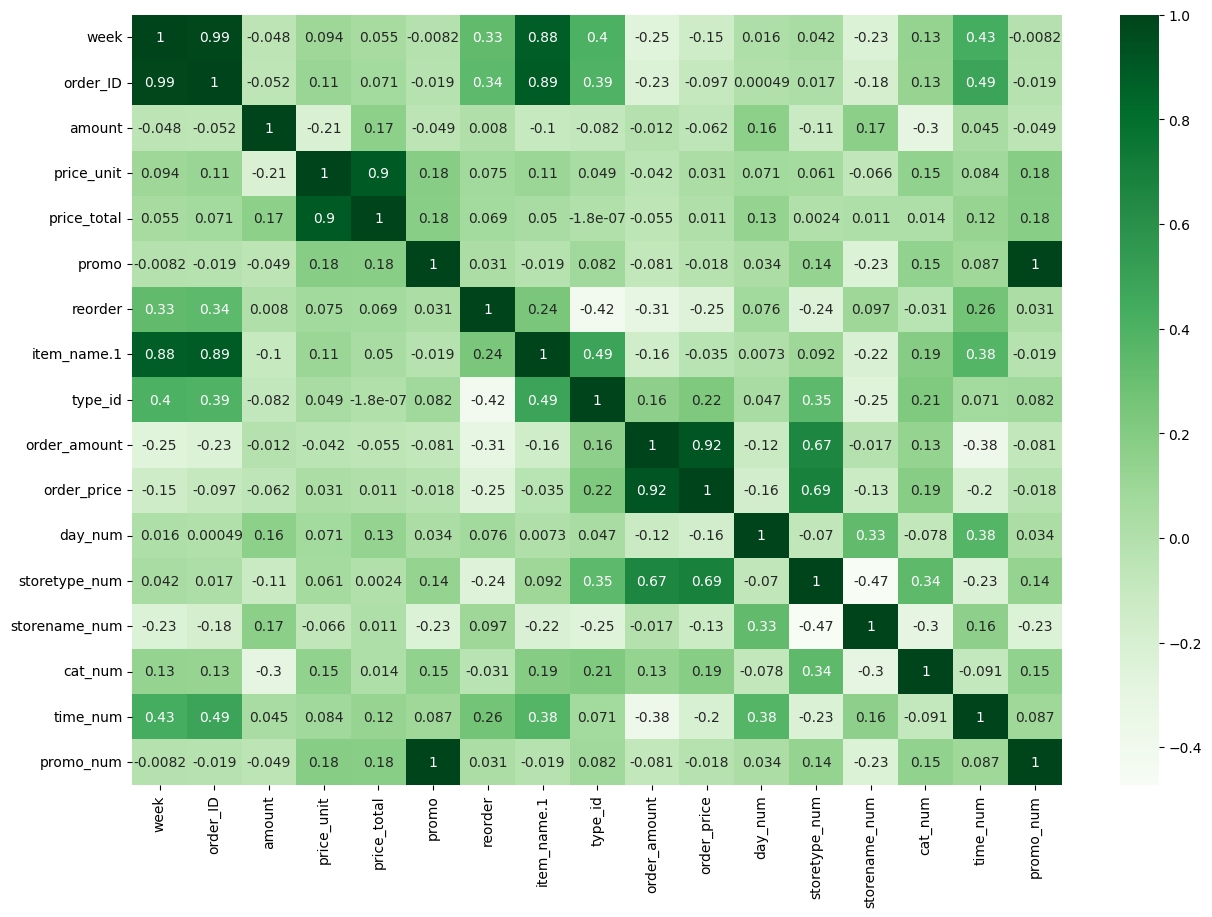

In [12]:
df_corr = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
df_corr.drop(['item_name', 'date', 'day', 'time', 'store_type', 'timestamp', 'store_name', 'item_type', 'category'], axis=1, inplace=True)


# use the corr function to display the correlation between all the features
data_corr = df_corr.corr()

#plotting correlation matrix 
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(data_corr, cmap="Greens", annot=True,)

## 2.2.1. DAYS

### Is there a noticeable pattern in this households shopping trips per week?

In [13]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")

# Create a dataframe for just the orders (not all individual items)
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# Cross tabulation between DAY and WEEK
CrosstabResult=pd.crosstab(index=df_orders['week'],columns=df_orders['day'])
CrosstabResult

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week,,,,,,,
1,0,2,1,0,1,0,0
2,0,0,2,2,0,0,3
3,0,0,0,1,1,1,2
4,0,0,1,0,0,1,3
5,2,2,0,0,0,3,0
6,0,1,0,0,0,1,1
7,1,0,0,1,0,1,0
8,2,0,1,1,1,0,0


We can see that this households shopping habits vary quite a lot per week. Generally we can only note that they do more grocery trips per day in the weekends (Saturday, Sunday)

#### Can we check whether shopping days are predictable over longer time periods?
(e.g.: every two weeks, they go shopping in the weekend)

In [14]:
#Let's try grouping per two (consecutive) dats
df_orders['week'] = df_orders['week'].replace([1, 2], 1)
df_orders['week'] = df_orders['week'].replace([3, 4], 2)
df_orders['week'] = df_orders['week'].replace([5, 6], 3)
df_orders['week'] = df_orders['week'].replace([7, 8], 4)

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# Cross tabulation between DAY and WEEK
CrosstabResult=pd.crosstab(index=df_orders['week'],columns=df_orders['day'])
CrosstabResult

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week,,,,,,,
1,0,2,3,2,1,0,3
2,0,0,1,1,1,2,5
3,2,3,0,0,0,4,1
4,3,0,1,2,1,1,0


> Are the first 4 weeks different from the last 4?

In [15]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")

# Create a dataframe for just the orders (not all individual items)
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()
df_orders.head()

,week,order_ID,store_name,storename_num,store_type,storetype_num,day,day_num,time,time_num,timestamp,order_amount,order_price
0,1,1,Okay,6,supermarket,4,Tuesday,5,noon,3,12:32:00,9,16.77000
5,1,2,Sys,7,bakery,0,Tuesday,5,noon,3,12:39:00,7,6.10000
8,1,3,Albert Heijn,0,supermarket,4,Wednesday,6,noon,3,12:32:00,2,6.99000
10,1,4,Delhaize,3,supermarket,4,Friday,0,afternoon,0,17:25:00,50,103.32998
54,2,5,Albert Heijn,0,supermarket,4,Wednesday,6,morning,2,11:43:00,1,3.99000


In [16]:
# group per period 1 and 2
df_orders['week'] = df_orders['week'].replace([1, 2, 3, 4], 1)
df_orders['week'] = df_orders['week'].replace([5, 6, 7, 8], 2)

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# Cross tabulation between DAY and WEEK
CrosstabResult=pd.crosstab(index=df_orders['week'],columns=df_orders['day'])
CrosstabResult

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week,,,,,,,
1,0,2,4,3,2,2,8
2,5,3,1,2,1,5,1


The first period seems to differ from the second period overall, but are there patterns in each separate period?

In [17]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
df_orders = df.loc[:, ('week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price')]
df_orders.drop_duplicates(inplace=True)

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# split up df to first and second period
df_period1 = df_orders[df_orders['week'] < 5]
df_period2 = df_orders[df_orders['week'] > 4]

# Cross tabulation between DAY and WEEK
CrosstabResult1=pd.crosstab(index=df_period1['week'],columns=df_period1['day'])
CrosstabResult2=pd.crosstab(index=df_period2['week'],columns=df_period2['day'])
display(CrosstabResult1)
display(CrosstabResult2)

day,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week,,,,,,
1,2,1,0,1,0,0
2,0,2,2,0,0,3
3,0,0,1,1,1,2
4,0,1,0,0,1,3


day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week,,,,,,,
5,2,2,0,0,0,3,0
6,0,1,0,0,0,1,1
7,1,0,0,1,0,1,0
8,2,0,1,1,1,0,0


> At least it seems they never shopped on Monday during the first period, rarely on Tuesday. They shopped on Sunday often (multiple trips). 

> Overall, we learn that there isn't really a generalizable pattern in this households shopping trips. It is hard to point to set days on which they do/don't shop.

+ We can however still look to see if they make a similar amount of shopping trips each week.
+ And we can check if there is a difference between weekends and weekdays

### Trips per week

In [18]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days, ordered=True)
df_dow = df.sort_values(by=['week','day'])

# grouping the variables for week, day and unique order id's
df_dow = df.groupby(['week', 'day'])['order_ID'].nunique()
df_dow = pd.DataFrame (df_dow)
df_dow.head()

# make grid for days vs. week
df_dowgrid1 = df_dow.groupby(['week', 'day'])['order_ID'].aggregate('first').unstack()
df_dowgrid1 = df_dowgrid1.reset_index()
df_dowgrid1.replace(0, np.nan, inplace=True)
df_dowgrid1

# second grid to generate extra variables
df_dowgrid2 = df_dowgrid1.copy()
del df_dowgrid2["week"]
# column for total grocery visits
df_dowgrid1['sum'] = df_dowgrid2.sum(axis=1)
# column for total days shopped
df_dowgrid1['ndays'] = df_dowgrid2.count(axis=1)
# column for median visits/week
df_dowgrid1['med'] = df_dowgrid2.median(numeric_only=True, axis=1)

df_dowgrid1 = df_dowgrid1.round(0)

/tmp/ipykernel_43817/598187879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dow = df.groupby(['week', 'day'])['order_ID'].nunique()
/tmp/ipykernel_43817/598187879.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dowgrid1 = df_dow.groupby(['week', 'day'])['order_ID'].aggregate('first').unstack()


In [19]:
# Make sure the numbers are rounded
df_dowgridNUM = df_dowgrid1.round(0)

# Drop irrelevant variables for the purpose of seeing amount of visits/week
df_dowgridNUM.drop(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, inplace=True)

# Show the table (and replace NaN with 0)
df_dowgridNUM.replace(np. nan,0)

day,week,sum,ndays,med
0,1,4.0,3,1.0
1,2,7.0,3,2.0
2,3,5.0,4,1.0
3,4,5.0,3,1.0
4,5,7.0,3,2.0
5,6,3.0,3,1.0
6,7,3.0,3,1.0
7,8,5.0,4,1.0


> There really are a set amount of days on which they shop: 3 or 4.

> The amount of trips on those days can vary (e.g. when they go the the supermarket ánd butcher ánd bakery on one shopping day vs when they don't do that another week).

> Generally they would go shopping just once or twice per shopping day.

### Weekends vs weekdays

In [20]:
# Make sure the numbers are rounded
df_dowgridWEEK = df_dowgrid1.round(0)
df_dowgridWEEK = df_dowgridWEEK.replace(np. nan,0)

# Aggregate weekdays and weekends
## Define a custom function to combine columns
def combine_columns(row):
    return (row['Monday']) + row['Tuesday'] + row['Wednesday']+ row['Thursday']+ row['Friday']
## Apply the custom function to create a new column 'Combined'
df_dowgridWEEK['Weekdays'] = df_dowgridWEEK.apply(combine_columns, axis=1)

df_dowgridWEEK['Weekends'] = df_dowgridWEEK['Saturday'] + df_dowgridWEEK['Sunday']

# Drop irrelevant variables for the purpose of seeing the difference between weekdays and weekends.
df_dowgridWEEK.drop(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'ndays', 'med', 'sum'], axis=1, inplace=True)

In [21]:
df_dowgridWEEK

day,week,Weekdays,Weekends
0,1,4.0,0.0
1,2,4.0,3.0
2,3,2.0,3.0
3,4,1.0,4.0
4,5,4.0,3.0
5,6,1.0,2.0
6,7,2.0,1.0
7,8,5.0,0.0


> IF they shop on weekends, it is likely multiple visits. Shoping during the week does not excluded shopping in the weekend.

### Build Algorithm to 'randomize' shopping days

#### Grid for dow/week & descriptions

In [22]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")

In [23]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days, ordered=True)
df_dow = df.sort_values(by=['week','day'])

# grouping the variables for week, day and unique order id's
df_dow = df.groupby(['week', 'day'])['order_ID'].nunique()
df_dow = pd.DataFrame (df_dow)
df_dow.head()

# make grid for days vs. week
df_dowgrid1 = df_dow.groupby(['week', 'day'])['order_ID'].aggregate('first').unstack()
df_dowgrid1 = df_dowgrid1.reset_index()
df_dowgrid1.replace(0, np.nan, inplace=True)
df_dowgrid1

# second grid to generate extra variables
df_dowgrid2 = df_dowgrid1.copy()
del df_dowgrid2["week"]
# column for total grocery visits
df_dowgrid1['sum'] = df_dowgrid2.sum(axis=1)
# column for total days shopped
df_dowgrid1['ndays'] = df_dowgrid2.count(axis=1)
# column for median visits/week
df_dowgrid1['med'] = df_dowgrid2.median(numeric_only=True, axis=1)

df_dowgrid1 = df_dowgrid1.round(0)

/tmp/ipykernel_43817/598187879.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dow = df.groupby(['week', 'day'])['order_ID'].nunique()
/tmp/ipykernel_43817/598187879.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dowgrid1 = df_dow.groupby(['week', 'day'])['order_ID'].aggregate('first').unstack()


In [24]:
df_shopweek = df_dowgrid1.round(0)
del df_shopweek["week"]

df_shopweek = df_shopweek.replace(np. nan,0)
df_shopweek

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,sum,ndays,med
0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,4.0,3,1.0
1,0.0,0.0,2.0,2.0,0.0,0.0,3.0,7.0,3,2.0
2,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,4,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,3.0,5.0,3,1.0
4,2.0,2.0,0.0,0.0,0.0,3.0,0.0,7.0,3,2.0
5,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3,1.0
6,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,3,1.0
7,2.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,4,1.0


In [25]:
df_shopweek.to_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/df_shopweek.csv", index = None, header=True)

### CONCLUSION (2.2.1. DAYS)

Needed data to build the algorithm:
> 1. Number of visits per day (per week)

> 2. Assign weights to each day (based on times shopped on these days)
    
    
We then have the first given:
> 1. Week 9: HH2 will shop on <b>Monday/Tuesday/..., X times</b>

## 2.2.2. STORE TYPE/NAME

From the correlation heatmap we knew that there was a correlation of 0.33 between day and store name, and only 0.07 with store stype. This is at least interesting enough to explore further. Let's try to visualize these correlations and figure out what they can tell us, if anything.

### check correlation per store TYPE

In [26]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
df_orders = df.loc[:, ('week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price')]
df_orders.drop_duplicates(inplace=True)

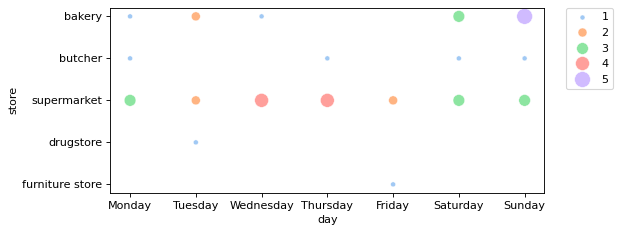

In [27]:
df_nunique = df.groupby(['day', 'store_type'])['order_ID'].nunique()
df_nunique = pd.DataFrame (df_nunique)
df_nunique = df_nunique.reset_index()
df_nunique = df_nunique.loc[~(df_nunique==0).any(axis=1)]


#order x and y axis chronologically
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_nunique['day'] = pd.Categorical(df_nunique['day'], order)
df_nunique.sort_values(by=['day'], inplace=True)


# select the x and y features
x = df_nunique['day']# select the x feature
y = df_nunique['store_type']# select the y feature

# select the feature that decides the colors
colors = df_nunique['order_ID'] # select the color column

# select the feature that will decide the size of the circle (and divide the value by 1000 for reshaping in the plot)
size = df_nunique['order_ID'] # select the column for the size and divide it by 1000 (/ 1000)

# fit the points with the scatter function
figure(figsize=(7, 3), dpi=80)
sns.scatterplot(x=x, y=y, palette="pastel", hue=colors, size=size, sizes=(20,200))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# give the graph a title and labels
plt.xlabel("day")
plt.ylabel('store')
# plt.title(f"The correlation between day & store type (r={current_corr})")

# call the graph (show function)
plt.grid(False)
plt.show()

> The only thing we can note here is that they go to the bakery more often during the weekend, while they do go to the supermarket during the weekends, but more often during the week (middle of the week: Wednesday and Thursday). Butcher and other stores are scattered across the week.

In [28]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
df_orders = df.loc[:, ('week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price')]
df_orders.drop_duplicates(inplace=True)

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# Cross tabulation between DAY and STORE TYPE
CrosstabResult=pd.crosstab(index=df_orders['store_type'],columns=df_orders['day'])
display(CrosstabResult)

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
store_type,,,,,,,
bakery,1,2,1,0,0,3,5
butcher,1,0,0,1,0,1,1
drugstore,0,1,0,0,0,0,0
furniture store,0,0,0,0,1,0,0
supermarket,3,2,4,4,2,3,3


> This just confirms our previous observations. Only the bakery seems to be visited more often during the weekend, and the supermarket mostly middle of the week, but also during the weekends.

In [29]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
df_orders = df.loc[:, ('week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price')]
df_orders.drop_duplicates(inplace=True)

# aggregate afternoon and evening
df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Saturday', 'Sunday'], 'weekend')

# aggregate afternoon and evening
df_orders.loc[:,('store_type')] = df_orders.loc[:,('store_type')].replace(['drugstore', 'furniture store'], 'other')
# df_orders.drop(df_orders[df_orders['store_type']== 'other'].index, inplace = True)
# df_orders['store_type'] = df_orders['store_type'].replace(['bakery', 'butcher'], 'bakery/butcher')

# Cross tabulation between DAY and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_type'],columns=df_orders['day'])

## normalize weekend (2days) vs weekdays(5days) by multiplying with 2.5 (5/2=2.5)
CrosstabResult.loc[:, ("weekend")] = CrosstabResult["weekend"] * 2.5

display(CrosstabResult)

day,weekday,weekend
store_type,,
bakery,4,20
butcher,2,5
other,2,0
supermarket,15,15


> CONCLUSION: when we normalize the weekend grocery trips vs the week trips, it is indeed clear that the bakery is something for during the weekends mostly. Supermarkets are visited equally during the week and weekends. And butchers mainly during the weekends, but just barely (also keep in mind again the limited dataset).  

In [30]:
# Cross tabulation between TIME and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_type'],columns=df_orders['time'])
display(CrosstabResult)

time,afternoon,evening,morning,noon
store_type,,,,
bakery,0,0,11,1
butcher,1,0,3,0
other,1,0,1,0
supermarket,3,3,7,8


> Looking at the times at which the different store types are visited, we see that the bakery is clearly a morning trip. The supermarket is mainly for the morning and noon, but it is also not unlikely they would shop there in the afternoon and in the evening

Can we find out more about the supermarket habits? Let's get more specific:
### check correlation per store NAME

In [31]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
df_orders = df.loc[:, ('week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price')]
df_orders.drop_duplicates(inplace=True)
# Drop stores that are not supermarkets
df_orders = df_orders.loc[~((df_orders['store_name'] == 'Brabo') | (df_orders['store_name'] == 'Ikea') | (df_orders['store_name'] == 'Kruidvat') | (df_orders['store_name'] == 'Sys') | (df_orders['store_name'] == 'Versavel Poelman'))]

In [32]:
# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# Cross tabulation between DAY and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_name'],columns=df_orders['day'])
display(CrosstabResult)

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
store_name,,,,,,,
Albert Heijn,3,0,4,2,1,0,1
Carrefour,0,0,0,0,0,1,0
Delhaize,0,0,0,0,1,0,2
Okay,0,2,0,2,0,2,0


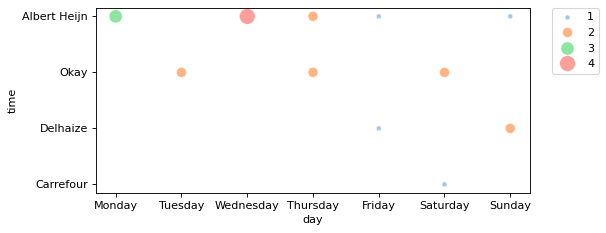

In [33]:
df = df.loc[~((df['store_name'] == 'Brabo') | (df['store_name'] == 'Ikea') | (df['store_name'] == 'Kruidvat') | (df['store_name'] == 'Sys') | (df['store_name'] == 'Versavel Poelman'))]
df_nunique = df.groupby(['day', 'store_name'])['order_ID'].nunique()
df_nunique = pd.DataFrame (df_nunique)
df_nunique = df_nunique.reset_index()
df_nunique = df_nunique.loc[~(df_nunique==0).any(axis=1)]

#order x and y axis chronologically
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_nunique['day'] = pd.Categorical(df_nunique['day'], order)
df_nunique.sort_values(by=['day'], inplace=True)


# select the x and y features
x = df_nunique['day']# select the x feature
y = df_nunique['store_name']# select the y feature

# select the feature that decides the colors
colors = df_nunique['order_ID'] # select the color column

# select the feature that will decide the size of the circle (and divide the value by 1000 for reshaping in the plot)
size = df_nunique['order_ID'] # select the column for the size and divide it by 1000 (/ 1000)

# fit the points with the scatter function
figure(figsize=(7, 3), dpi=80)
sns.scatterplot(x=x, y=y, palette="pastel", hue=colors, size=size, sizes=(20,200))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# give the graph a title and labels
plt.xlabel("day")
plt.ylabel('time')

# call the graph (show function)
plt.grid(False)
plt.show()

In [34]:
# Drop stores that are not supermarkets
df_orders = df_orders.loc[~((df_orders['store_name'] == 'Brabo') | (df_orders['store_name'] == 'Ikea') | (df_orders['store_name'] == 'Kruidvat') | (df_orders['store_name'] == 'Sys') | (df_orders['store_name'] == 'Versavel Poelman'))]

# aggregate weekday and weekend
df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Saturday', 'Sunday'], 'weekend')

# Cross tabulation between DAY and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_name'],columns=df_orders['day'])

## normalize weekend (2days) vs weekdays(5days) by multiplying with 2.5 (5/2=2.5)
CrosstabResult.loc[:, ("weekend")]= CrosstabResult["weekend"] * 2.5
display(CrosstabResult)

/tmp/ipykernel_43817/809143583.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
/tmp/ipykernel_43817/809143583.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['weekday', 'weekday', 'weekday', 'weekday', 'weekday', ..., 'Saturday', 'Saturday', 'Sunday', 'Sunday', 'Sunday']
Length: 21
Categories (3, object): ['weekday', 'Saturday', 'Sunday']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
/tmp/ipykern

day,weekday,weekend
store_name,,
Albert Heijn,10,2.5
Carrefour,0,2.5
Delhaize,1,5.0
Okay,4,5.0


> Albert Heijn (supermarket) seems to be a store they would much more often visit during the week. Okay (supermarket) then again does not really seem to matter week vs weekend. Delhaize and Carrefour (supermarkets) finally are much more often visited during the weekend. 

### CONCLUSION (2.2.2. Store)
We now have an idea for the first two steps in generating week 9 groceries:
> 1. It is <b>day X</b>

> 2. The HH will shop at <b>store NAME X</b> (linked to day of the week)

The choice for selecting store name and not store type is because the shopping habits of this household on which store they visit when (which day of the week) really do seem different vs. Albert Heijn and Delhaize/Carrefour/Okay. This goes beyond just store types (e.g. bakery vs supermarket)

## 2.2.3. TIME
From the correlation heatmap of the complete dataset we knew that there was a correlation of 0.38 between day and time, which is at least interesting enough to explore further.

### 2.2.3.1 DAY vs TIME (all orders)

In [35]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
df_orders = df.loc[:, ('week','order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price')]
df_orders.drop_duplicates(inplace=True)

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
time,,,,,,,
afternoon,0,1,0,2,1,1,0
evening,1,0,0,1,0,1,0
morning,2,2,2,1,1,5,9
noon,2,2,3,1,1,0,0


> The only noticeable pattern is that in the weekend, the would usually shop in the morning. During the week, it can vary between afternoon, morning, and noon; rarely afternoon.

#### Let's see afternoon and evening as one group

In [36]:
# Create a dataframe for just the orders (not all individual items)
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
time,,,,,,,
afternoon,1,1,0,3,1,2,0
morning,2,2,2,1,1,5,9
noon,2,2,3,1,1,0,0


#### Now let's try grouping weekdays and weekends

In [37]:
# Create a dataframe for just the orders (not all individual items)
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# aggregate weekday and weekend
df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df_orders.loc[:,('day')] = df_orders.loc[:,('day')].replace(['Saturday', 'Sunday'], 'weekend')

# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

# Cross tabulation between DAY and TIME
CrosstabResult=pd.crosstab(index=df_orders['time'],columns=df_orders['day'])
display(CrosstabResult)

day,weekday,weekend
time,,
afternoon,6,2
morning,8,14
noon,9,0


> They indeed shop most often in the morning during the weekend. On weekdays it varies a lot.

### 2.2.3.2 DAY VS TIME @ SPECIFIED STORE

In [38]:
# Create a dataframe for just the orders (not all individual items)
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

# Cross tabulation between TIME and STORE NAME
CrosstabResult=pd.crosstab(index=df_orders['store_name'],columns=df_orders['time'])
display(CrosstabResult)


time,afternoon,morning,noon
store_name,,,
Albert Heijn,1,3,7
Brabo,1,0,0
Carrefour,1,0,0
Delhaize,1,2,0
Ikea,0,1,0
Kruidvat,1,0,0
Okay,3,2,1
Sys,0,11,1
Versavel Poelman,0,3,0


#### Now we select each individual store name to see their relationship between day and time

In [39]:
# Create a dataframe for just the orders (not all individual items)
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

# to select only one
store1 = 'Albert Heijn'
store2 = 'Sys'
store3 = 'Okay'
store4 = 'Delhaize'
store5 = 'Versavel Poelman'
store6 = 'Kruidvat'
store7 = 'Brabo'
store8 = 'Ikea'
store9 = 'Carrefour'

# select only these data for the df
df_store1 = df_orders[df_orders['store_name'] == store1]
df_store2 = df_orders[df_orders['store_name'] == store2]
df_store3 = df_orders[df_orders['store_name'] == store3]
df_store4 = df_orders[df_orders['store_name'] == store4]
df_store5 = df_orders[df_orders['store_name'] == store5]
df_store6 = df_orders[df_orders['store_name'] == store6]
df_store7 = df_orders[df_orders['store_name'] == store7]
df_store8 = df_orders[df_orders['store_name'] == store8]
df_store9 = df_orders[df_orders['store_name'] == store9]

# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_store1['time'],columns=df_store1['day'])
CrosstabResult2=pd.crosstab(index=df_store2['time'],columns=df_store2['day'])
CrosstabResult3=pd.crosstab(index=df_store3['time'],columns=df_store3['day'])
CrosstabResult4=pd.crosstab(index=df_store4['time'],columns=df_store4['day'])
CrosstabResult5=pd.crosstab(index=df_store5['time'],columns=df_store5['day'])
CrosstabResult6=pd.crosstab(index=df_store6['time'],columns=df_store6['day'])
CrosstabResult7=pd.crosstab(index=df_store7['time'],columns=df_store7['day'])
CrosstabResult8=pd.crosstab(index=df_store8['time'],columns=df_store8['day'])
CrosstabResult9=pd.crosstab(index=df_store9['time'],columns=df_store9['day'])
print('SUPERMARKET:')
print('Albert Heijn:')
display(CrosstabResult1)
print('Okay:')
display(CrosstabResult3)
print('Delhaize:')
display(CrosstabResult4)
print('Carrefour:')
display(CrosstabResult9)

print('BAKERY:')
print('Sys:')
display(CrosstabResult2)

print('BUTCHER:')
print('Versavel Poelman:')
display(CrosstabResult5)
print('Brabo:')
display(CrosstabResult7)

print('OTHER:')
print('Kruidvat:')
display(CrosstabResult6)
print('Ikea:')
display(CrosstabResult8)


SUPERMARKET:
Albert Heijn:


day,Monday,Wednesday,Thursday,Friday,Sunday
time,,,,,
afternoon,1,0,0,0,0
morning,0,1,1,0,1
noon,2,3,1,1,0


Okay:


day,Tuesday,Thursday,Saturday
time,,,
afternoon,0,2,1
morning,1,0,1
noon,1,0,0


Delhaize:


day,Friday,Sunday
time,,
afternoon,1,0
morning,0,2


Carrefour:


day,Saturday
time,
afternoon,1


BAKERY:
Sys:


day,Monday,Tuesday,Wednesday,Saturday,Sunday
time,,,,,
morning,1,1,1,3,5
noon,0,1,0,0,0


BUTCHER:
Versavel Poelman:


day,Monday,Saturday,Sunday
time,,,
morning,1,1,1


Brabo:


day,Thursday
time,
afternoon,1


OTHER:
Kruidvat:


day,Tuesday
time,
afternoon,1


Ikea:


day,Friday
time,
morning,1


#### Now we also look at each individual store TYPE to see their relationship between day and time

In [40]:
# Create a dataframe for just the orders (not all individual items)
df_orders = df[['week', 'order_ID', 'store_name', 'storename_num', 'store_type', 'storetype_num','day', 'day_num', 'time', 'time_num', 'timestamp', 'order_amount', 'order_price']]
df_orders = df_orders.drop_duplicates()

# make sure the days of the week are in the right order
df_orders['day'] = pd.Categorical(df_orders['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_orders=df_orders.sort_values(by='day')

# aggregate afternoon and evening
df_orders['time'] = df_orders['time'].replace(['afternoon', 'evening'], 'afternoon')

# to select only one store type
storet1 = 'supermarket'
storet2 = 'butcher'
storet3 = 'bakery'

df_storet1 = df_orders[df_orders['store_type'] == storet1]
df_storet2 = df_orders[df_orders['store_type'] == storet2]
df_storet3 = df_orders[df_orders['store_type'] == storet3]


# Cross tabulation between DAY and TIME
CrosstabResult1=pd.crosstab(index=df_storet1['time'],columns=df_storet1['day'])
print("day vs time for supermarkets:")
display(CrosstabResult1)

# Cross tabulation between DAY and TIME
CrosstabResult2=pd.crosstab(index=df_storet2['time'],columns=df_storet2['day'])
print("day vs time for butchers:")
display(CrosstabResult2)

# Cross tabulation between DAY and TIME
CrosstabResult3=pd.crosstab(index=df_storet3['time'],columns=df_storet3['day'])
print("day vs time for bakeries:")
display(CrosstabResult3)

day vs time for supermarkets:


day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
time,,,,,,,
afternoon,1,0,0,2,1,2,0
morning,0,1,1,1,0,1,3
noon,2,1,3,1,1,0,0


day vs time for butchers:


day,Monday,Thursday,Saturday,Sunday
time,,,,
afternoon,0,1,0,0
morning,1,0,1,1


day vs time for bakeries:


day,Monday,Tuesday,Wednesday,Saturday,Sunday
time,,,,,
morning,1,1,1,3,5
noon,0,1,0,0,0


> Bakeries and butchers really are visited almost always in the morning. Supermarkets can be visited at all times of the day, but during the week mostly at noon (as is known from interviews with this household, this is most likely for lunch during work; at Albert Heijn)

### CONCLUSION (2.2.3. Time)

##### If they go to store X (on day Y) => at X time (morning, noon, afternoon)

We now have an idea for the first two steps in generating week 9 groceries:
> 1. It is <b>day X</b>

> 2. The HH will shop at <b>store NAME X</b>

> 3. The HH will shop at <b>time X</b> (morning; noon; afternoon -- related to store type)

## 2.2.4. CATEGORIES
From the correlation heatmap of the complete dataset we knew that there was a correlation of 0.34 between category and store type, and -0.3 with store name, which is at least interesting enough to explore further.

### 2.2.4.1 CATEGORIES VS STORE TYPE

In [41]:
# aggregate "other" store types
df.loc[:,('store_type')] = df.loc[:,('store_type')].replace(['drugstore', 'furniture store'], 'other')

# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['store_type'])
CrosstabResult

store_type,bakery,butcher,other,supermarket
category,,,,
bakery,32,0,0,5
beverages,0,0,3,23
breakfast & spreads,0,0,0,8
canned foods,0,0,0,13
care & hyygiene,0,0,1,0
condiments,0,0,0,5
cooking aid,0,0,0,4
dairy & plant based,1,1,0,52
frozen foods,0,0,0,16


> This makes a lot of sense; bakery items are mainly bought at the bakery, though sometimes they also buy meat,fish, & veggie at the bakery (we know that this is a meat spread from the interviews) and sometimes dairy (butter). Fruit & vegetables are by far the most popular category in the supermarket. Other stores (Ikea, Kruidvat) are for care & hygiene and beverages, sometimes snacks. 

### 2.2.4.2 CATEGORIES VS STORE NAME

In [42]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['store_name'])
CrosstabResult

store_name,Albert Heijn,Brabo,Carrefour,Delhaize,Ikea,Kruidvat,Okay,Sys,Versavel Poelman
category,,,,,,,,,
bakery,1,0,0,3,0,0,1,32,0
beverages,2,0,0,10,2,1,11,0,0
breakfast & spreads,1,0,1,1,0,0,5,0,0
canned foods,0,0,1,1,0,0,11,0,0
care & hyygiene,0,0,0,0,0,1,0,0,0
condiments,0,0,1,2,0,0,2,0,0
cooking aid,0,0,0,0,0,0,4,0,0
dairy & plant based,5,0,8,16,0,0,23,1,1
frozen foods,0,0,0,1,0,0,15,0,0


> Delhaize is by far most popular for their fruit & vegetables, followed by Okay (these are also just the most popular supermarkets for this household). Okay does seem to be the most popular supermarket for frozen foods and canned foods over the other supermarkets. 

### 2.2.4.3 CATEGORIES VS WEEK

In [43]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['week'])
display(CrosstabResult)

week,1,2,3,4,5,6,7,8
category,,,,,,,,
bakery,5,6,9,5,6,5,0,1
beverages,5,2,6,0,7,3,1,2
breakfast & spreads,1,1,2,1,1,1,0,1
canned foods,4,3,2,1,3,0,0,0
care & hyygiene,0,0,0,0,0,1,0,0
condiments,0,2,0,1,0,2,0,0
cooking aid,0,1,0,0,3,0,0,0
dairy & plant based,5,4,13,8,11,7,1,5
frozen foods,0,1,2,0,11,0,2,0


> Per week, the categories vary (they buy different things more or less per week; e.g., 9 bakery in week 3 but none in week 8). They don't buy frozen foods often, though they stocked up on them in week 11 (at Okay). 
Thus we cannot easily use this as a steady limit variable; it is hard to know when they will buy more or less of something. 

### 2.2.4.4 CATEGORIES VS DAY & VS TIME

Although there really is no indication that there would be any correlation there, let's see how categories are spread accross time (day and times)

In [52]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")

# make sure the days of the week are in the right order
df['day'] = pd.Categorical(df['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df=df.sort_values(by='day')

# aggregate afternoon and evening
df['time'] = df['time'].replace(['afternoon', 'evening'], 'afternoon')

# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['day'])
display(CrosstabResult)

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
category,,,,,,,
bakery,3,4,3,1,2,8,16
beverages,2,5,0,3,7,4,5
breakfast & spreads,1,2,0,3,0,1,1
canned foods,0,3,0,5,1,4,0
care & hyygiene,0,1,0,0,0,0,0
condiments,0,0,0,2,0,1,2
cooking aid,0,3,0,1,0,0,0
dairy & plant based,6,6,0,11,4,15,12
frozen foods,0,4,0,2,0,9,1


In [63]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")

# make sure the days of the week are in the right order
df['day'] = pd.Categorical(df['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df=df.sort_values(by='day')

# aggregate weekday and weekend
df.loc[:,('day')] = df.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df.loc[:,('day')] = df.loc[:,('day')].replace(['Saturday', 'Sunday'], 'weekend')

# aggregate afternoon and evening
df['time'] = df['time'].replace(['afternoon', 'evening'], 'afternoon')

# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['day'])
display(CrosstabResult)

/tmp/ipykernel_43817/1502138592.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.loc[:,('day')] = df.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
/tmp/ipykernel_43817/1502138592.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['weekday', 'weekday', 'weekday', 'weekday', 'weekday', ..., 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday']
Length: 372
Categories (3, object): ['weekday', 'Saturday', 'Sunday']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:,('day')] = df.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
/tmp/ipykernel_43817/1502138592.py:9: Fut

day,weekday,weekend
category,,
bakery,13,24
beverages,17,9
breakfast & spreads,6,2
canned foods,9,4
care & hyygiene,1,0
condiments,2,3
cooking aid,4,0
dairy & plant based,27,27
frozen foods,6,10


> Beyond bakery items in the weekend, and many of the smaller categories during the week (cooking aid, non-food, pasta & rice...), there is no real pattern to be spotted in these crosstabs.

In [64]:
# make sure the days of the week are in the right order
df['day'] = pd.Categorical(df['day'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df=df.sort_values(by='day')

# aggregate afternoon and evening
df['time'] = df['time'].replace(['afternoon', 'evening'], 'afternoon')

# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['category'],columns=df['time'])
display(CrosstabResult)

time,afternoon,morning,noon
category,,,
bakery,4,30,3
beverages,12,14,0
breakfast & spreads,5,2,1
canned foods,7,3,3
care & hyygiene,1,0,0
condiments,3,2,0
cooking aid,1,3,0
dairy & plant based,29,24,1
frozen foods,4,12,0


> Same here; bakery seems to be in the morning, and the biggest noon category is fruit & veggies. Other than that no noteable patterns.

## 2.2.5. ITEM TYPES

In [69]:
df = pd.read_csv (r"/workspaces/DesignerlyAlgorithmicPrototyping/database/Groceries_onehousehold.csv")
# df.describe(include='all')
# aggregate afternoon and evening
df['time'] = df['time'].replace(['afternoon', 'evening'], 'afternoon')

# # select only these data (for time)
# df_morning = df[df["time"] == morning]
# df_noon = df[df["time"] == noon]
# df_afternoon = df[df["time"] == afternoon]


# aggregate weekday and weekend
df.loc[:,('day')] = df.loc[:,('day')].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday')
df.loc[:,('day')] = df.loc[:,('day')].replace(['Saturday', 'Sunday'], 'weekend')

# aggregate "other" store types
df.loc[:,('store_type')] = df.loc[:,('store_type')].replace(['drugstore', 'furniture store'], 'other')

#### 2.2.5.1 item type vs promo

In [70]:
# Cross tabulation between category and store type
CrosstabResult =pd.crosstab(index=df['item_type'],columns=df['promo_num'])

CrosstabResult

promo_num,0,1
item_type,,
alcoholic drinks,1,0
almond milk,1,0
andalouse sauce,1,0
apple sauce,4,0
apples,2,0
...,...,...
tonic,1,0
vegetable box,0,2
vegetable mix,1,2


We could separate items that are more often than not bought when they are in promo

##### (if for promo #1>#0)

In [71]:
CrosstabResult.drop(CrosstabResult[CrosstabResult[1] <= CrosstabResult[0]].index, inplace = True)
CrosstabResult = CrosstabResult.reset_index()
CrosstabResult

promo_num,item_type,0,1
0,blueberries,0,2
1,fish,1,2
2,fruit salad,0,1
3,lunch,0,3
4,vegetable box,0,2
5,vegetable mix,1,2


In [73]:
promoitems = CrosstabResult.item_type.values.tolist()
promoitems

['blueberries',
 'fish',
 'fruit salad',
 'lunch',
 'vegetable box',
 'vegetable mix']

> It might be sensible to remove these items from the dataframe since we have no control over whether the store they will visit in week 9 will have these items in promo